# Udacicy CarND Term1 Project 5 Vehicle Detection
---
### In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4)

## 1. Train the SVM Classifier

### Load the Data

In [1]:
import glob
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label

% matplotlib inline

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Explore the Features
#### View HOG Features

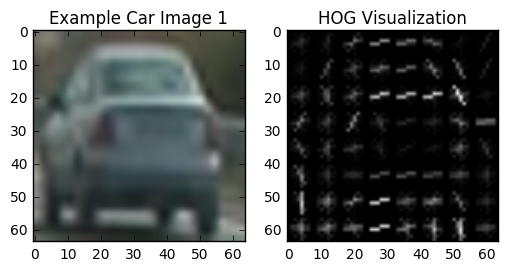

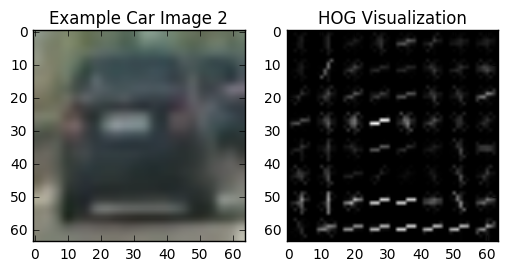

In [5]:

car1 = mpimg.imread('./feature_example/car1.png')
car2 = mpimg.imread('./feature_example/car2.png')
orient = 9
pix_per_cell = 8
cell_per_block = 2
gray1 = cv2.cvtColor(car1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(car2, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(gray1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
features2, hog_image2 = get_hog_features(gray2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car1, cmap='gray')
plt.title('Example Car Image 1')
plt.subplot(122)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car2, cmap='gray')
plt.title('Example Car Image 2')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

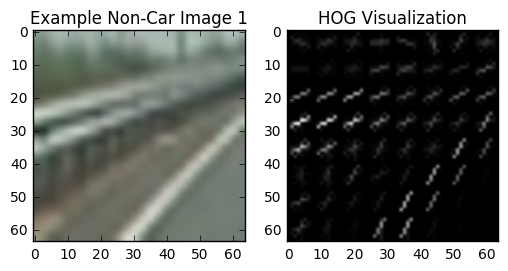

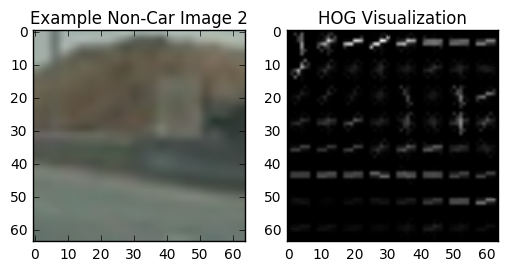

In [6]:
noncar1 = mpimg.imread('./feature_example/noncar1.png')
noncar2 = mpimg.imread('./feature_example/noncar2.png')
orient = 9
pix_per_cell = 8
cell_per_block = 2
gray1 = cv2.cvtColor(noncar1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(noncar2, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(gray1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
features2, hog_image2 = get_hog_features(gray2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(noncar1, cmap='gray')
plt.title('Example Non-Car Image 1')
plt.subplot(122)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(noncar2, cmap='gray')
plt.title('Example Non-Car Image 2')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

#### View the Color Space

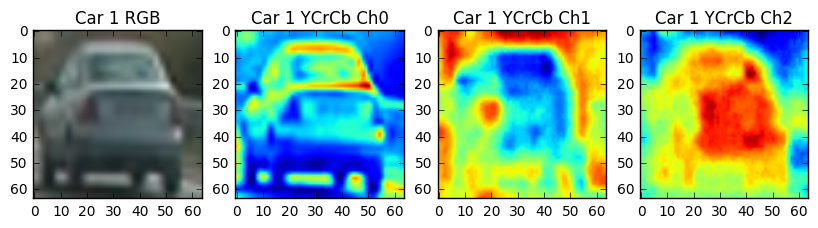

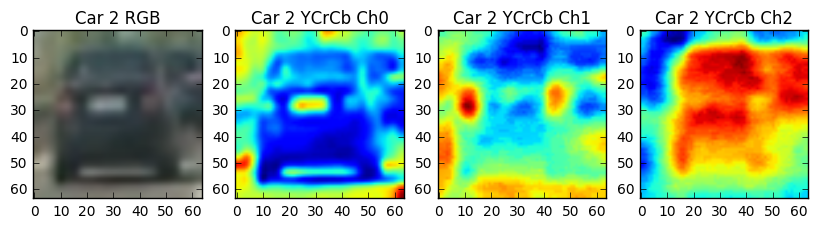

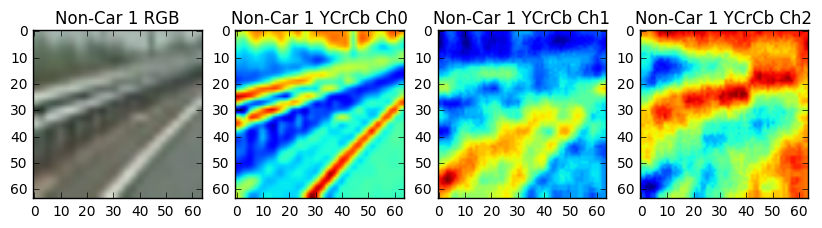

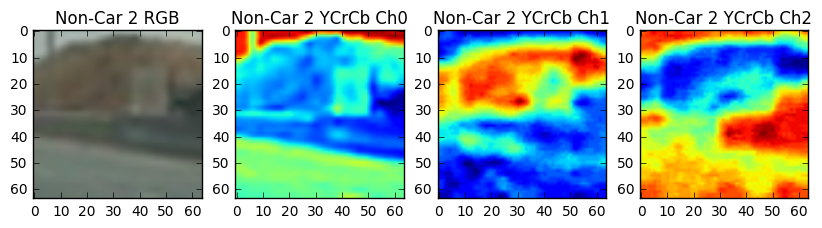

In [7]:
car1_YCrCb = cv2.cvtColor(car1, cv2.COLOR_RGB2YCrCb)
car2_YCrCb = cv2.cvtColor(car2, cv2.COLOR_RGB2YCrCb)
noncar1_YCrCb = cv2.cvtColor(noncar1, cv2.COLOR_RGB2YCrCb)
noncar2_YCrCb = cv2.cvtColor(noncar2, cv2.COLOR_RGB2YCrCb)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(car1)
ax1.set_title('Car 1 RGB', fontsize=12)
ax2.imshow(car1_YCrCb[:,:,0])
ax2.set_title('Car 1 YCrCb Ch0', fontsize=12)
ax3.imshow(car1_YCrCb[:,:,1])
ax3.set_title('Car 1 YCrCb Ch1', fontsize=12)
ax4.imshow(car1_YCrCb[:,:,2])
ax4.set_title('Car 1 YCrCb Ch2', fontsize=12)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(car2)
ax1.set_title('Car 2 RGB', fontsize=12)
ax2.imshow(car2_YCrCb[:,:,0])
ax2.set_title('Car 2 YCrCb Ch0', fontsize=12)
ax3.imshow(car2_YCrCb[:,:,1])
ax3.set_title('Car 2 YCrCb Ch1', fontsize=12)
ax4.imshow(car2_YCrCb[:,:,2])
ax4.set_title('Car 2 YCrCb Ch2', fontsize=12)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(noncar1)
ax1.set_title('Non-Car 1 RGB', fontsize=12)
ax2.imshow(noncar1_YCrCb[:,:,0])
ax2.set_title('Non-Car 1 YCrCb Ch0', fontsize=12)
ax3.imshow(noncar1_YCrCb[:,:,1])
ax3.set_title('Non-Car 1 YCrCb Ch1', fontsize=12)
ax4.imshow(noncar1_YCrCb[:,:,2])
ax4.set_title('Non-Car 1 YCrCb Ch2', fontsize=12)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(noncar2)
ax1.set_title('Non-Car 2 RGB', fontsize=12)
ax2.imshow(noncar2_YCrCb[:,:,0])
ax2.set_title('Non-Car 2 YCrCb Ch0', fontsize=12)
ax3.imshow(noncar2_YCrCb[:,:,1])
ax3.set_title('Non-Car 2 YCrCb Ch1', fontsize=12)
ax4.imshow(noncar2_YCrCb[:,:,2])
ax4.set_title('Non-Car 2 YCrCb Ch2', fontsize=12)


### Extract the features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Train SVM Calssifier

#### Load the images

In [9]:
t = time.time()
carFiles = glob.glob("./data/vehicles/*/*.png", recursive=True)
print("Loading car files...")
cars = []
for image in carFiles:
    cars.append(image)

nonCarFiles = glob.glob("./data/non-vehicles/*/*.png", recursive=True)
notcars = []
print("Loading non-car files...")
for image in nonCarFiles:
    notcars.append(image)

t2 = time.time()
print(round(t2 - t, 2), 'seconds to load the images.')  
print("Number of Car Images:", len(cars))
print("Number of Non-car Images:", len(notcars))


Loading car files...
Loading non-car files...
0.17 seconds to load the images.
Number of Car Images: 8792
Number of Non-car Images: 8968


#### Setting the Hyper-parameters

In [10]:
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

#### Extract Features of the Images

In [33]:
t = time.time()

print("Extracting car features")
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
print("Extracting non-car features")
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t, 2), 'seconds to extract the features.')  


X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using spatial binning of:',spatial_size[0],'and', hist_bins,'histogram bins')
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block.')
print('Feature vector length:', len(X_train[0]))


Extracting car features
Extracting non-car features
101.36 seconds to extract the features.
Using spatial binning of: 32 and 32 histogram bins
Using: 9 orientations 8 pixels per cell and 2 cells per block.
Feature vector length: 8460


In [34]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
print("Training SVC Classifier...")
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to train SVC.')

Training SVC Classifier...
39.66 seconds to train SVC.


In [35]:
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
0.02726 seconds to predict 10 labels with SVC


In [36]:
t=time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t2 = time.time()
print(round(t2-t, 5), 'seconds to compute the test accuracy.')

filename = "svm_model/svm.pkl"
joblib.dump(svc, filename)
pickle.dump(scaled_X,open("svm_model/scaled_X_data.pkl","wb"))
pickle.dump(y,open("svm_model/y_data.pkl","wb"))

print("The trained model is saved.")

Test Accuracy of SVC =  0.991
0.85373 seconds to compute the test accuracy.
The trained model is saved.


In [39]:
pickle.dump(X_scaler, open("svm_model/X_scaler.pkl","wb"))

### Save the Training parameters

In [38]:
data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('svm_model/model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)
    

### Video Car Detection Model is in Another Jyputer Notebook